In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
import mkl
mkl.set_num_threads(1)

48

In [3]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/e_psf_grid_psimax-3_bins-25_KDE.pckl
running gaussian-process resolution smoothing
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [4]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import LOCALPATH, BASEPATH, sigma1, sigma3, sigma5
import settings as st
from tools import array_source_interp, poisson_llh, get_scaler
from tqdm import tqdm

# Settings

In [5]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

# helper functions

In [6]:
def scaling_estimation(
    df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5
):
    """Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors"""

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new

    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1

    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [7]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

# Atmospheric background


In [8]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [9]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


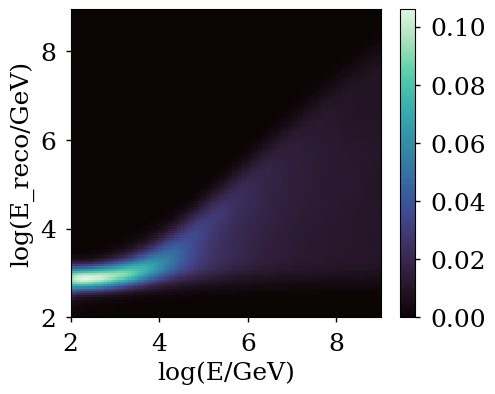

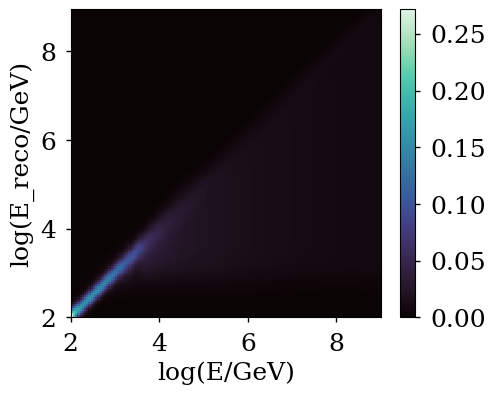

In [10]:
# full range, easy plotting
baseline_eres.plot()
improved_eres.plot()

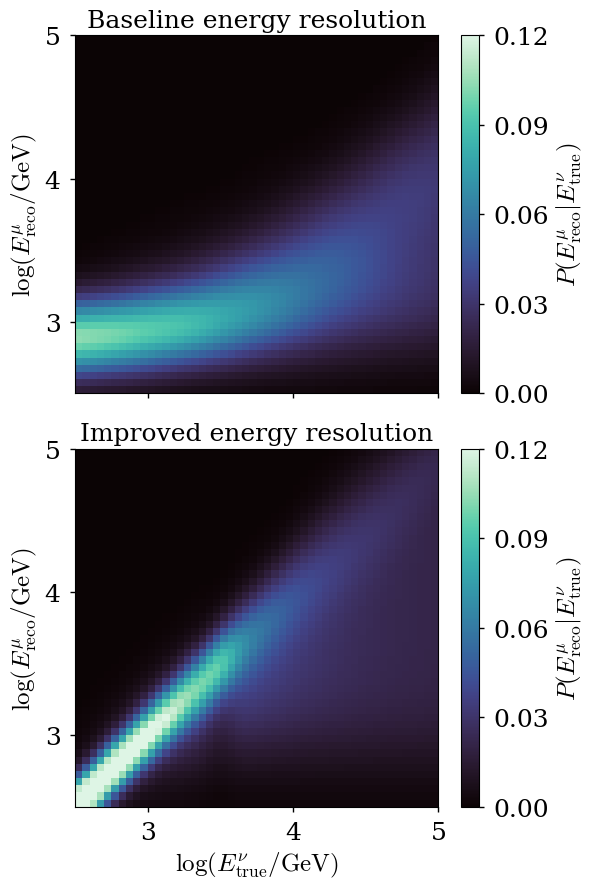

In [11]:
# nice plot
ebounds = (2.5, 5)

f, axes = plt.subplots(nrows=2, figsize=(6, 9), sharex=True)
f, ax = mephisto.plot_mephistogram(baseline_eres, f=f, ax=axes[0], vmin=0, vmax=0.12,
    linewidth=0,
    rasterized=True,)
ax.set_xlabel("")
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.collections[0].colorbar.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
ax.collections[0].colorbar.set_ticks(np.arange(0, 0.13, step=0.03))
ax.set_title("Baseline energy resolution")
ax.set_yticks([3, 4, 5])

f, ax = mephisto.plot_mephistogram(improved_eres, f=f, ax=axes[1], vmin=0, vmax=0.12,
    linewidth=0,
    rasterized=True,)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.set_xlabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
cb = ax.collections[0].colorbar
cb.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
cb.set_ticks(np.arange(0, 0.13, step=0.03))
ax.set_title("Improved energy resolution")
ax.set_yticks([3, 4, 5])

f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/energy_resolution_comparison.pdf"))

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [12]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

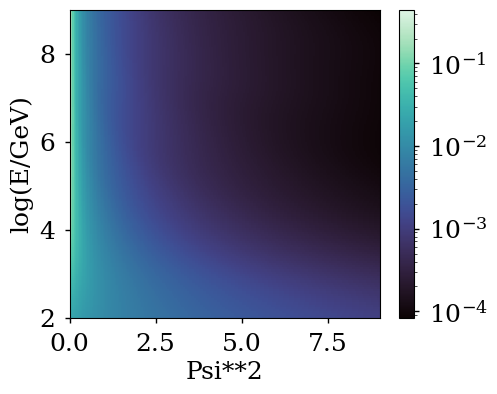

In [13]:
e_psi2_grid.plot(norm=LogNorm())

# Flux definition

In [14]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 source parameters

In [15]:
from settings import PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME

In [16]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

In [17]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

## Check event numbers

In [18]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10**aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85

ngc 1068: 88.11995357633094


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [19]:
from fluxes import astro_flux

In [20]:
def ps_llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    )
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        10**aeff_factor_signal.bin_mids[1],
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def ps_llh_multi(
    x,
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_bckg_flux,
    all_k,
    all_eres,
    shape,
    e_0,
    phi_0,
):
    """
    Calculate the total log-likelihood across multiple datasets with different properties.

    Parameters:
        x (list): Fit parameters.
        all_aeff_factor_s (list): List of effective area factors for the signal for each dataset.
        all_aeff_factor_b (list): List of effective area factors for the background for each dataset.
        all_bckg_flux (list): List of background flux values for each dataset.
        all_k (list): List of observation/Asimov data for each dataset.
        all_eres (list): List of energy resolutions for each dataset.
        shape (str): Flux shape.
        e_0 (float): Normalization energy.
        phi_0 (float): Normalization flux.

    Returns:
        float: Total log-likelihood value across all datasets.

    Note:
        This function assumes that there are multiple datasets with different properties.
    """
    llh = 0
    for i, aeffs in enumerate(all_aeff_factor_s):
        llh += ps_llh_single(
            x=x,
            aeff_factor_s=aeffs,
            aeff_factor_b=all_aeff_factor_b[i],
            bckg_flux=all_bckg_flux[i],
            k_i=all_k[i],
            energy_resolution=all_eres[i],
            e_0=e_0,
            phi_0=phi_0,
            shape=shape,
        )
    return llh
def setup_multi_llh(eres, conf, bg_config, sig_config, src_flux=ngc_flux, verbose=False, return_s_b=False):
    """
    Set up the components required for calculating the log-likelihood across multiple datasets.

    Parameters:
        eres (dict or array): Dictionary of arrays/mephistograms or single array/mephistogram representing the
                                  energy resolutions for each dataset. If a dictionary is provided,
                                  it should map dataset identifiers to their corresponding energy resolution.
                                  If a float is provided, the same energy resolution will be used for all datasets.
        conf (tuple): Tuple containing two lists - the first list represents dataset identifiers,
                      and the second list contains corresponding scaling factors corresponding to
                      either a lifetime scaling or effective-area scaling.
        verbose (bool, optional): Whether to print additional information. Default is False.
        return_s_b (bool, optional): Whether to return the individual signal and background histograms. Default is False.

    Returns:
        tuple: A tuple containing the following components for each dataset:
            - all_aeff_factor_s (list): List of effective area factors for the signal.
            - all_aeff_factor_b (list): List of effective area factors for the background.
            - all_k (list): List of observation/Asimov data.
            - all_bckg_flux (list): List of background flux values.
            - if return_s_b: all_k_s, all_k_b (lists): List of signal and background histograms

    Note:
        This function assumes that the configuration parameters and required functions (e.g., `calc_aeff_factor`,
        `atmo_background`, `astro_flux`, `array_source_interp`) are defined and accessible in the global namespace.
        If `eres` is a dictionary, each dataset identifier should have an associated energy resolution value.
        If `eres` is an  array/mephistogram, the same energy resolution will be used for all datasets.
    """

    all_aeff_factor_s = []
    all_aeff_factor_b = []
    all_k = []
    all_bckg_flux = []
    all_eres = []
    if return_s_b:
        all_k_s = []
        all_k_b = []

    for ident, factor in zip(*conf):
        # Calculate effective area factors for background and signal
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **bg_config) * factor
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **sig_config) * factor

        # Calculate background flux
        bckg_flux = array_source_interp(
            bg_config["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
        )
        # Determine the energy resolution for the current dataset
        current_eres = eres[ident] if isinstance(all_eres, dict) else eres

        # Calculate asimov data for atmospheric background
        k_b = atmo_background(
            aeff_factor=aeff_factor_bckg,
            bckg_vals=bckg_flux,
            energy_resolution=current_eres,
        )

        # Calculate asimov data for astrophysical signal with power law spectrum
        k_s = astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=10**aeff_factor_signal.bin_mids[1],
            energy_resolution=current_eres,
            phi_scaling=1,
            flux_shape=src_flux,  # powerlaw
        )

        if verbose:
            print("Asimov data sum:")
            print("Background:", np.sum(k_b))
            print("Signal:", np.sum(k_s))

        all_aeff_factor_s.append(aeff_factor_signal)
        all_aeff_factor_b.append(aeff_factor_bckg)
        all_k.append(k_s + k_b)
        all_bckg_flux.append(bckg_flux)
        all_eres.append(current_eres)
        if return_s_b:
            all_k_s.append(k_s)
            all_k_b.append(k_b)
    if return_s_b:
        return (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        )
    else:
        return all_aeff_factor_s, all_aeff_factor_b, all_k, all_bckg_flux, all_eres

In [27]:
def setup_single_llh(
    eres,
    conf_i,
    bg_config,
    sig_config,
    src_flux=ngc_flux,
    verbose=False,
    return_s_b=False,
):
    """
    Set up the components required for calculating the log-likelihood across multiple datasets.

    Parameters:
        eres (dict or array): Dictionary of arrays/mephistograms or single array/mephistogram representing the
                                  energy resolutions for each dataset. If a dictionary is provided,
                                  it should map dataset identifiers to their corresponding energy resolution.
                                  If a float is provided, the same energy resolution will be used for all datasets.
        conf_i (tuple): Tuple containing two items - the first item is the dataset identifier,
                      and the second item is the scaling factor corresponding to
                      either a lifetime scaling or effective-area scaling.
        verbose (bool, optional): Whether to print additional information. Default is False.
        return_s_b (bool, optional): Whether to return the individual signal and background histograms. Default is False.

    Returns:
        tuple: A tuple containing the following components for each dataset:
            - all_aeff_factor_s : effective area factors for the signal.
            - all_aeff_factor_b : effective area factors for the background.
            - all_k : observation/Asimov data.
            - all_bckg_flux : background flux values.
            - if return_s_b: all_k_s, all_k_b : signal and background histograms

    Note:
        This function assumes that the configuration parameters and required functions (e.g., `calc_aeff_factor`,
        `atmo_background`, `astro_flux`, `array_source_interp`) are defined and accessible in the global namespace.
        If `eres` is a dictionary, each dataset identifier should have an associated energy resolution value.
        If `eres` is an  array/mephistogram, the same energy resolution will be used for all datasets.
    """

    ident, factor = conf_i
    # Calculate effective area factors for background and signal
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **bg_config) * factor
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **sig_config) * factor

    # Calculate background flux
    bckg_flux = array_source_interp(
        bg_config["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
    )

    # Calculate asimov data for atmospheric background
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=bckg_flux,
        energy_resolution=eres,
    )

    # Calculate asimov data for astrophysical signal with power law spectrum
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=10 ** aeff_factor_signal.bin_mids[1],
        energy_resolution=eres,
        phi_scaling=1,
        flux_shape=src_flux,  # powerlaw
    )

    if verbose:
        print("Asimov data sum:")
        print("Background:", np.sum(k_b))
        print("Signal:", np.sum(k_s))

    if return_s_b:
        return (
            aeff_factor_signal,
            aeff_factor_bckg,
            k_s + k_b,
            bckg_flux,
            k_b,
            k_s,
        )
    else:
        return aeff_factor_signal, aeff_factor_bckg, k_s + k_b, bckg_flux

# NGC 1068
## Significance test Background vs. Background + Signal

In [22]:
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        baseline_eres,
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.07337098]
Signal fit parameters: [1.  1.  3.2]
TS check: -321949.9495939726 (fit:  -321949.9495939726 )
-2 Delta LLH: 21.00930051098112
P-VALUE: 2.7408695100140704e-05 SIGNIFICANCE: 4.034076792238222

Plenum-1
Atmo-only normalization: [1.09869251]
Signal fit parameters: [1.  1.  3.2]
TS check: -1425175.6229016667 (fit:  -1425175.6229016667 )
-2 Delta LLH: 115.26337176025845
P-VALUE: 9.351404423249288e-26 SIGNIFICANCE: 10.426827869344068

Plenum-2
Atmo-only normalization: [1.08159547]
Signal fit parameters: [1.  1.  3.2]
TS check: -1383178.79942194 (fit:  -1383178.79942194 )
-2 Delta LLH: 253.32127680489793
P-VALUE: 9.817110230874154e-56 SIGNIFICANCE: 15.683435196325512



# Significance with improved PSF
We model the improved PSF simply with a background norm reduction. This implies that the shape of the PSF stays the same, but it's a reasonable estimate.

### find the characteristic angular scale

Text(0.5, 0, '$\\Psi$ (deg)')

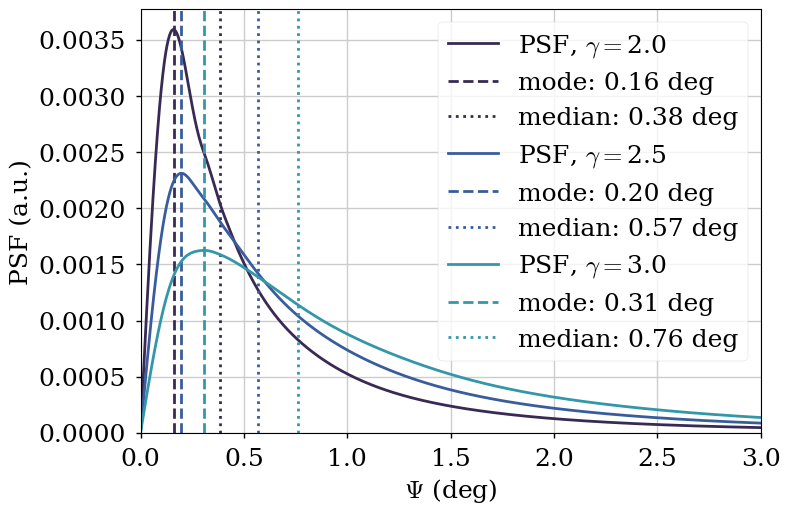

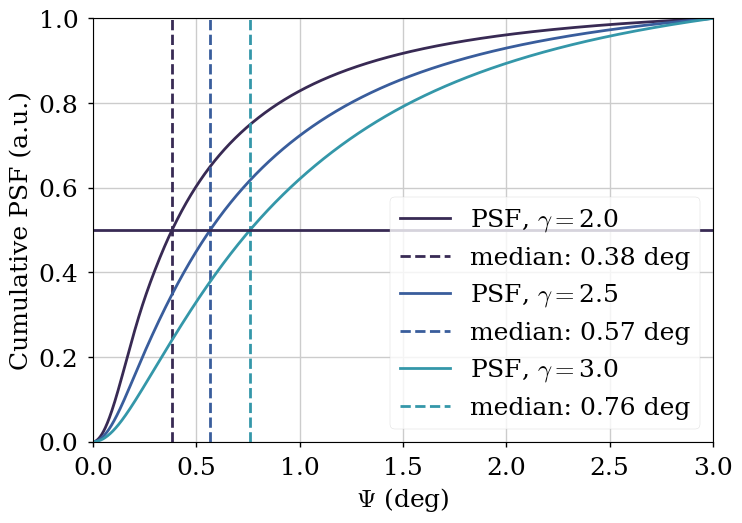

In [23]:
aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
psi_eval = np.linspace(0, st.delta_psi_max, num=1500)
modes = {}
medians = {}
for gamma in [2.0, 2.5, 3.0]:  # , 3.2]:
    tmp_flux = PL_flux(1e-14, gamma, 1e3, "powerlaw")

    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=10 ** aeff_factor_signal.bin_mids[1],
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=tmp_flux,  # powerlaw
    )
    # transform from psi^2 back to psi to get an characteristic angular scale
    spl = InterpolatedUnivariateSpline(k_s.bin_mids[0], k_s.sum(axis=1))
    psf = 2 * psi_eval * spl(psi_eval**2)
    psf /= np.sum(psf)
    plt.figure(1)
    p = plt.plot(psi_eval, psf, label=rf"PSF, $\gamma=${gamma}")
    modes[gamma] = psi_eval[np.argmax(psf)]
    medians[gamma] = psi_eval[np.cumsum(psf)>=0.5][0]
    plt.axvline(
        modes[gamma],
        label=f"mode: {modes[gamma]:1.2f} deg",
        ls="--",
        color=p[0].get_color(),
    )
    plt.axvline(
        medians[gamma],
        label=f"median: {medians[gamma]:1.2f} deg",
        ls=":",
        color=p[0].get_color(),
    )
    plt.figure(2)
    p = plt.plot(psi_eval, np.cumsum(psf), label=rf"PSF, $\gamma=${gamma}")
    plt.axvline(
        medians[gamma],
        label=f"median: {medians[gamma]:1.2f} deg",
        ls="--",
        color=p[0].get_color(),
    )
plt.axhline(0.5)

plt.figure(1)
plt.legend()
plt.ylim(0, None)
plt.xlim(0, st.delta_psi_max)
plt.ylabel("PSF (a.u.)")
plt.xlabel(r"$\Psi$ (deg)")

plt.figure(2)
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, st.delta_psi_max)
plt.ylabel("Cumulative PSF (a.u.)")
plt.xlabel(r"$\Psi$ (deg)")

### scale the BG down to mimic a better PSF

Idea:
* background scales quadratically with the analysis window radius
* a scale of 1 corresponds to the standard PSF
* a wider PSF requires a larger search window, so to first order, we assume that a wider or slimmer PSF can be approximated as a larger or smaller background rate
* as the search window is a 2D circle, the background rate scales quadratically
* we neglect e.g. effects by a change in background rate within the search window

In [159]:
ident = "IceCube"
conf = (ident, 1)
psf_scale = np.logspace(-1, 1, num=50)
psf_scale = np.sort(np.concatenate([[1], psf_scale]))
results = []
tmp_flux = PL_flux(1e-17, 2, 1e3, "powerlaw")
for lt_scaling, psf_s in product([1/16, 1/4, 1, 4, 16], psf_scale):
    bg_r = psf_s**2  
    # background scales quadratically with the analysis window radius
    # a scale of 1 corresponds to the standard PSF
    # a wider PSF requires a larger search window
    # so to first order, we assume that a wider or slimmer PSF can be approximated as a larger or smaller background rate
    # as the search window is somewhat like a 2D circle, the background rate scales quadratically
    # we neglect e.g. effects by a change in background rate within the search window
    cur_bg_conf = ngc_bg_config.copy()
    cur_s_conf = ngc_src_config.copy()

    cur_bg_conf["livetime"] *= bg_r * lt_scaling * 100
    cur_s_conf["livetime"] *= lt_scaling * 100
    aeff_factor_s, aeff_factor_b, k, bckg_flux = setup_single_llh(
        energy_reso["baseline"],  # select one resolution for all data sets
        conf,
        bg_config=cur_bg_conf,
        sig_config=cur_s_conf,
        src_flux=tmp_flux,
    )

    dct = dict(
        shape="powerlaw",
        aeff_factor_s=aeff_factor_s,
        aeff_factor_b=aeff_factor_b,
        k_i=k,
        bckg_flux=bckg_flux,
        energy_resolution=energy_reso["baseline"],
        e_0=tmp_flux.E0,
        phi_0=tmp_flux.norm,
    )
    # fix signal contribution to 0 for background fit
    local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_single(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, tmp_flux.gamma),
        approx_grad=True,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    results.append(
        {
            "significance": significance,
            "pval": pval,
            "ident": f"IC + {ident}" if ident == "P-ONE" else ident,
            "bg_reduction": bg_r,
            "psf_improvement": psf_s,
            "livetime_scaling": lt_scaling
        }
    )
results = pd.DataFrame(results)

Text(0.5, 0, 'background scaling factor')

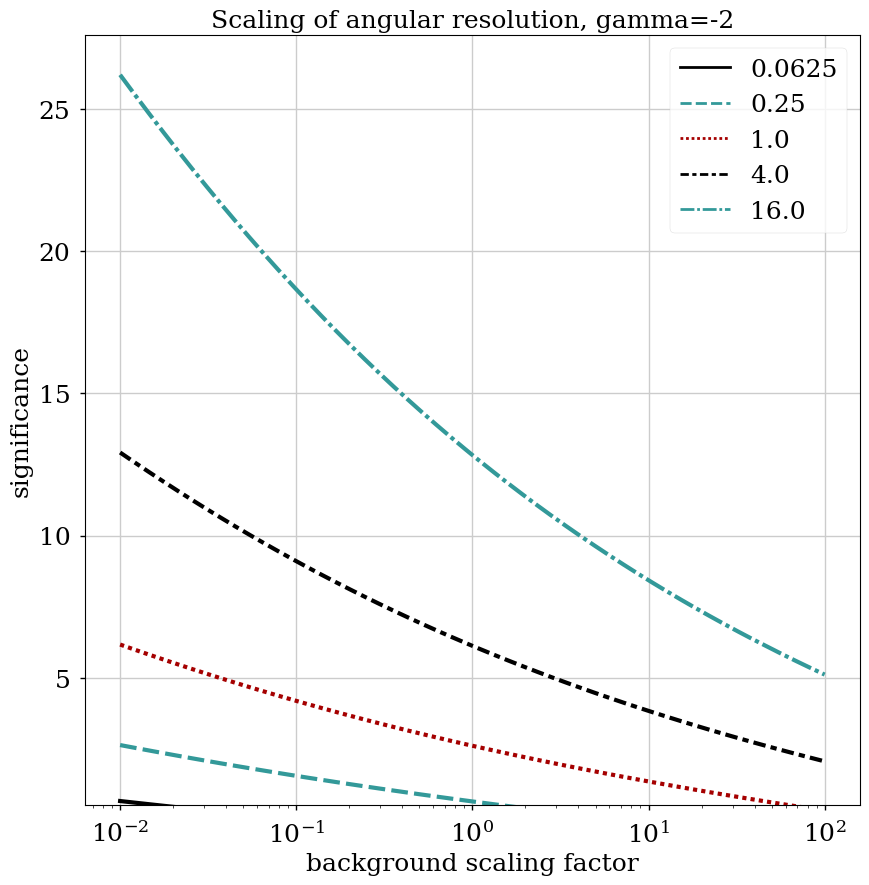

In [160]:
current_gamma = 2
results["characteristic_ang"] = modes[current_gamma] * results["psf_improvement"]
results["background_scaling"] = results["psf_improvement"]**2
plt.figure(figsize=(10, 10))
ax = sns.lineplot(
    data=results,
    x="bg_reduction", #"psf_improvement",# "characteristic_ang",
    y="significance",
    style="livetime_scaling",
    hue="livetime_scaling",
    lw=3,
    palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
#plt.axvline(modes[current_gamma], label="current", color="0.4", lw=2, ls="-.")
#ax.loglog()
ax.set_xscale("log")
#ax.set_xlim(0.1, 2)
ax.set_ylim(0.5, None)
plt.legend(loc=1)
legend = ax.get_legend()
legend.set_title(None)
ax.set_title("Scaling of angular resolution, gamma=-2")
#ax.set_ylabel("Significance NGC 1068")
ax.set_xlabel("background scaling factor")
#ax.set_xlabel("Characteristic angle of PSF")

## change vs zenith

In [104]:
# standard
thresholds = [sigma5]
ident = "IceCube"
conf = (ident, 1)
decs = [0.5] #np.arcsin(np.linspace(0, 0.9, num=10))
target_resolutions = ["base", 10, 5, 1.4, 1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01]  # deg
# target_resolutions = ["base", 1.2, 0.6, 0.4, 0.08] # deg
gammas = [2]
tmp = []  # save output here
psf_reference_val = "median"  #  or "median"
for gamma, dec in product(gammas, decs):
    tmp_flux = PL_flux(1e-16, gamma, 1e3, "powerlaw")

    # insert the declination into the configs
    cur_bg_conf = bg_config.copy()
    cur_bg_conf["dec"] = dec

    cur_sig_conf = src_config.copy()
    cur_sig_conf["dec"] = dec

    # set up all ingredients for the likelihood calculation
    (
        aeff_factor_s,
        aeff_factor_b,
        k_i,
        bckg_flux,
        k_b,
        k_s,
    ) = setup_single_llh(
        energy_reso["baseline"],  # select one resolution for all data sets
        conf,
        bg_config=cur_bg_conf,
        sig_config=cur_sig_conf,
        return_s_b=True,
        src_flux=tmp_flux,
    )

    # transform from psi^2 back to psi to get an characteristic angular scale
    spl = InterpolatedUnivariateSpline(k_s.bin_mids[0], k_s.sum(axis=1))
    psf = 2 * psi_eval * spl(psi_eval**2)
    psf /= np.sum(psf)
    if psf_reference_val == "mode":
        ref_psf = psi_eval[np.argmax(psf)]
    elif psf_reference_val == "median":
        ref_psf = psi_eval[np.cumsum(psf) >= 0.5][0]

    for a_res in target_resolutions:
        cur_bg_aeff_factor = np.copy(aeff_factor_b)
        cur_bg_k = np.copy(k_b)

        if a_res != "base":
            # background scales quadratically with the analysis window radius
            bg_rate_scale = (ref_psf / a_res ) ** 2
            cur_bg_aeff_factor *= bg_rate_scale
            cur_bg_k *= bg_rate_scale
            

        # print(dec, a_res, np.sum(cur_bg_k), np.sum())
        # calculate an estimate for the flux scaling
        scaler = 1 / (np.sum(k_s) / np.sqrt(np.sum(cur_bg_k)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the 5-sigma discovery threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = k_s * scaler
            current_k_i = current_k_s + cur_bg_k

            dct = dict(
                shape="powerlaw",
                aeff_factor_s=aeff_factor_s,
                aeff_factor_b=cur_bg_aeff_factor,
                k_i=current_k_i,
                bckg_flux=bckg_flux,
                energy_resolution=energy_reso["baseline"],
                e_0=tmp_flux.E0,
                phi_0=tmp_flux.norm,
            )
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_single(x, **dct)

            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, tmp_flux.gamma),
                approx_grad=True,
            )
            logP = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2))
            if np.isnan(logP):
                scaler /= 2
                continue
            if not np.isfinite(logP):
                scaler *= 2
                continue
            tmp_dct = {
                "ident": ident,
                "baseline_psf": ref_psf,
                "baseline_reference": psf_reference_val,
                "bckg_scaling": bg_rate_scale,
                "gamma": gamma,
                "psf_scale": a_res,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(cur_bg_k)),
                "n_b": np.sum(cur_bg_k),
                "n_sig": np.sum(current_k_s),
                "log10(p)": logP,
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.gamma == gamma)
                & (tmp_df.psf_scale == a_res)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break
        if False:
            plt.figure()
            plt.title(a_res)
            plt.plot(
                np.concatenate([[-0.1], st.psi2_mids]),
                np.concatenate([[0], current_k_s.sum(axis=1)]),
                drawstyle="steps-mid",
                color="k",
                lw=3,
            )

            plt.plot(
                np.concatenate([[-0.1], st.psi2_mids]),
                np.concatenate([[0], cur_bg_k.sum(axis=1)]),
                drawstyle="steps-mid",
                color="#339999",
                lw=3,
                zorder=0,
            )
            plt.xlim(0, 1)
            plt.show()
    # break
df = pd.DataFrame(tmp)

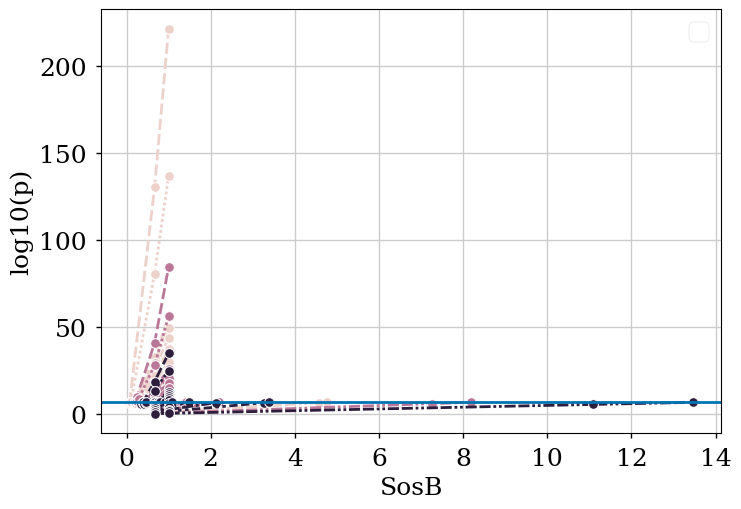

In [91]:
ax = sns.lineplot(
    data=df, #.loc[df.psf_scale == "base"],
    y="log10(p)",
    x="SosB",
    hue="dec",
    marker="o",
    style="psf_scale",
)
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)

In [61]:
sns.set_palette("colorblind")

In [108]:
flux = pd.DataFrame(
    df.groupby(["psf_scale", "dec", "gamma", "bckg_scaling", "baseline_psf"]).apply(
        lambda x: get_scaler(x, sigma5)
    )
    * tmp_flux.norm,
    columns=["disc5"],
).reset_index()


Text(0.5, 1.0, 'Powerlaw flux, $\\gamma=-2$')

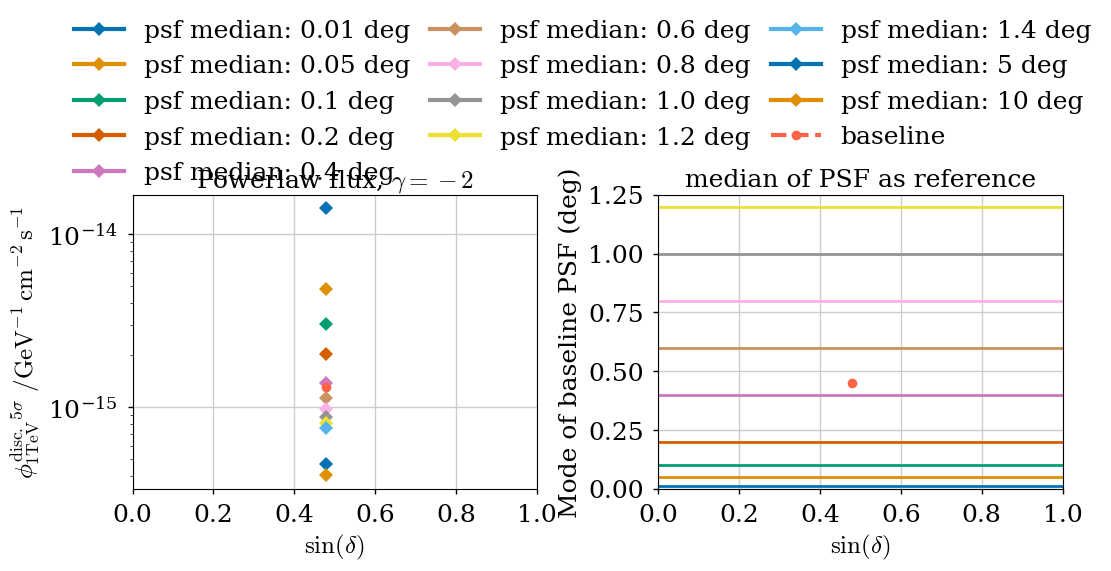

In [109]:

f, (ax, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
for ident, series in flux.groupby("psf_scale"):
    p = ax.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        marker="o" if ident == "base" else "D",
        label=f"psf {psf_reference_val}: {ident} deg" if ident != "base" else f"baseline",
        ls="--" if ident == "base" else "-",
        color="tomato" if ident == "base" else None,
    )
    if ident == "base":
        ax2.plot(np.sin(series.dec), series.baseline_psf, color="tomato", ls="--", marker="o")
    else:
        ax2.axhline(ident, color=p[0].get_color())
ax2.set_ylabel("Mode of baseline PSF (deg)")
ax2.set_ylim(0, 1.25)
ax.set_yscale("log")
ax2.set_title(psf_reference_val + " of PSF as reference")

ax.set_xlabel(r"$\sin(\delta)$")
ax2.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=3,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
# ax.set_ylim(8e-15, 1e-13)
ax.set_xlim(0, 1)
ax2.set_xlim(0, 1)
f.subplots_adjust(top=0.6, wspace=0.3)
ax.set_title(r"Powerlaw flux, $\gamma=-2$")

Text(0.5, 0, 'Bckg scaling ratio')

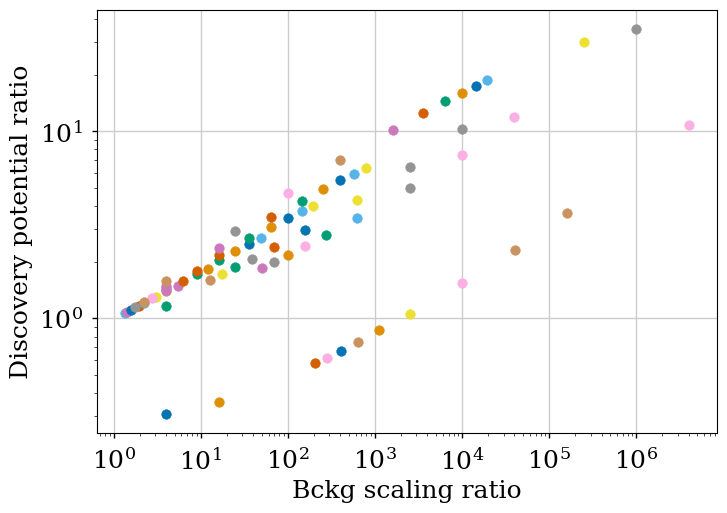

In [106]:
split_flux = list(flux.groupby("bckg_scaling"))
for ii, (psf_i, sf) in enumerate(split_flux):
    if psf_i == "base":
        continue
    for jj in range(0, ii):
        plt.scatter(
            np.full_like(decs, psf_i/split_flux[jj][0]),
            sf["disc5"].values / split_flux[jj][1]["disc5"].values,
        )
plt.loglog()
plt.ylabel("Discovery potential ratio")
plt.xlabel("Bckg scaling ratio")

In [93]:
flux.to_csv("psf_scaling_discovery_potential.csv")

## different detectors

In [ ]:
detector_keys = ["IceCube", "P-ONE", "Plenum-1"]
psf_scale = np.logspace(-0.6, 1, num=20)
psf_scale = np.sort(np.concatenate([[1], psf_scale]))
results = []

for ident, psf_s in product(detector_keys, psf_scale):
    conf = st.detector_configurations[ident]
    bg_r = psf_s**2  # background scales quadratically with the analysis window radius
    # a scale of 1 corresponds to the standard PSF
    # a wider PSF requires a larger search window
    # so to first order, we assume that a wider or slimmer PSF can be approximated as a larger or smaller background rate
    # as the search window is somewhat like a 2D circle, the background rate scales quadratically
    # we neglect e.g. effects by a change in background rate within the search window
    cur_bg_conf = ngc_bg_config.copy()
    cur_bg_conf["livetime"] *= bg_r
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        energy_reso["baseline"],  # select one resolution for all data sets
        conf,
        bg_config=cur_bg_conf,
        sig_config=ngc_src_config,
        src_flux=ngc_flux
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )
    # fix signal contribution to 0 for background fit
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    results.append(
        {
            "significance": significance,
            "pval": pval,
            "ident": f"IC + {ident}" if ident == "P-ONE" else ident,
            "bg_reduction": bg_r,
            "psf_improvement": psf_s,
        }
    )
results = pd.DataFrame(results)

Text(0.5, 0, 'Characteristic angle of PSF')

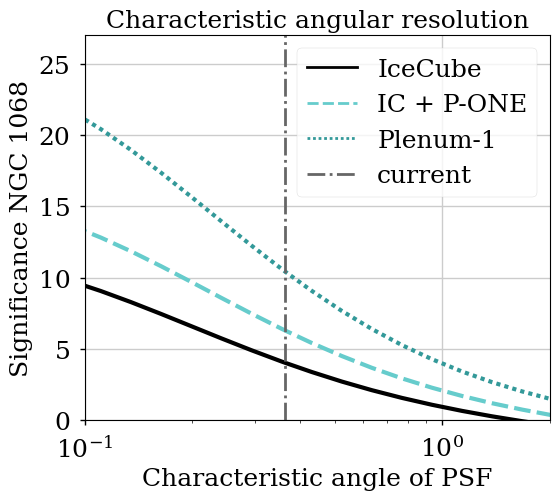

In [ ]:
results["characteristic_ang"] = modes[3.2] * results["psf_improvement"]
plt.figure(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x="characteristic_ang",
    y="significance",
    style="ident",
    hue="ident",
    lw=3,
    palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
plt.axvline(modes[3.2], label="current", color="0.4", lw=2, ls="-.")
ax.set_xscale("log")
ax.set_xlim(0.1, 2)
ax.set_ylim(0, 27)
plt.legend(loc=1)
legend = ax.get_legend()
legend.set_title(None)
ax.set_title("Characteristic angular resolution")
ax.set_ylabel("Significance NGC 1068")
ax.set_xlabel("Characteristic angle of PSF")
#plt.savefig(join(BASEPATH, "plots/ngc_paper/angular_improvement.pdf"))